# SDH Conference Paper Test Case 1

This tutorial shows how to let modesto solve a simple network.

## Imports and other stuff

In [1]:
from __future__ import division

import logging
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import modesto.utils as ut
from modesto.main import Modesto

In [2]:
%matplotlib notebook

In [3]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-36s %(levelname)-8s %(message)s',
                    datefmt='%m-%d %H:%M')
logger = logging.getLogger('Main.py')

## Network graph

A first step is to make a networkX object of the network you would like to optimize:

For the model to load correctly into modesto, you need to add some attributes to each of the nodes and edges.

For the nodes (besides the name of the node):
* **x, y, and z**: coordinates of the node in meter
* **comps**: a dictionary containing all components (except the network pipes) that are connected to the nodes. The keys of the dictionary are the names of the components, the values are the types of the components.

For the edges (besides names of the nodes where the edge starts and stops):
* **Name of the edge**
    

In [4]:
G = nx.DiGraph()

G.add_node('SolarArray', x=0, y=5000, z=0,
           comps={'solar': 'SolarThermalCollector'})

G.add_node('WaterscheiGarden', x=0, y=0,  z=0,
           comps={'neighb': 'BuildingFixed'})

G.add_node('p1', x=1000, y=2400, z=0, comps={})

G.add_node('p2', x=4000, y=2800, z=0, comps={})

G.add_node('TermienWest', x=4200, z=0, y=4600, 
           comps={'neighb': 'BuildingFixed'})

G.add_node('Production', x=6000, y=4000, z=0, comps={'backup': 'ProducerVariable'})
G.add_node('TermienEast', x=5400, y=200, z=0, comps={'neighb': 'BuildingFixed'})

In [5]:
G.add_edge('SolarArray', 'p1', name='servSol')
G.add_edge('p1', 'WaterscheiGarden', name='servWat')
G.add_edge('p1', 'p2', name='backBone')
G.add_edge('p2', 'TermienWest', name='servTer')
G.add_edge('p2', 'TermienEast', name='servBox')
G.add_edge('Production', 'p2', name='servPro')

In [6]:
pos = {}
for node in G:
    #print node
    pos[node] = (G.nodes[node]['x'], G.nodes[node]['y'])


nx.draw_networkx(G, with_labels=True, font_weight='bold', pos=pos)


<IPython.core.display.Javascript object>

## Setting up modesto

Decide the following characteristics of the optimization problem:
* **Horizon** of the optimization problem (in seconds)
* **Time step** of the (discrete) problem (in seconds)
* **Start time** (should be a pandas TimeStamp). Currently, weather and prixe data for 2014 are available in modesto.
* **Pipe model**: The type of model used to model the pipes. Only one type can be selected for the whole optimization problem (unlike the component model types). Possibilities: SimplePipe (= perfect pipe, no losses, no time delays), ExtensivePipe (limited mass flows and heat losses, no time delays) and NodeMethod (heat losses and time delays, but requires mass flow rates to be known in advance)

In [7]:
horizon = 7*24*3600
time_step = 3600
start_time = pd.Timestamp('20140104')
pipe_model = 'ExtensivePipe'

And create the modesto object

In [8]:
optmodel = Modesto(horizon=horizon,
                   time_step=time_step,
                   pipe_model=pipe_model, 
                   graph=G,
                   start_time=start_time)

02-15 11:04 modesto.parameter.Parameter          INFO     Initializing Parameter Te
02-15 11:04 modesto.parameter.Parameter          INFO     Initializing Parameter Tg
02-15 11:04 modesto.Node                         INFO     Initializing Node p2
02-15 11:04 modesto.Node                         INFO     Build of p2 finished
02-15 11:04 modesto.Node                         INFO     Initializing Node p1
02-15 11:04 modesto.Node                         INFO     Build of p1 finished
02-15 11:04 modesto.Node                         INFO     Initializing Node SolarArray
02-15 11:04 modesto.component.Component          INFO     Initializing Component solar
02-15 11:04 modesto.parameter.Parameter          INFO     Initializing Parameter area
02-15 11:04 modesto.parameter.Parameter          INFO     Initializing Parameter delta_T
02-15 11:04 modesto.parameter.Parameter          INFO     Initializing Parameter heat_profile
02-15 11:04 modesto.components.SolThermCol       INFO     Initializing So

## Adding data

modesto is now aware of the position and interconnections between components, nodes and edges, but still needs information rergarding, weather, prices, customer demands, component sizing, etc.


### Collect data

modesto provides some useful data handling methods (found in modesto.utils). Most notable is read_time_data, that can load time-variable data from a csv file. In this example, the data that is available in the folder modesto/Data is used.

#### Weather data:

In [9]:
from pkg_resources import resource_filename
datapath = resource_filename('modesto', 'Data')

In [10]:
wd = ut.read_time_data(datapath, name='Weather/weatherData.csv')
t_amb = wd['Te']
t_g = wd['Tg']

#### Electricity price

In [11]:
c_f = ut.read_time_data(path=datapath,name='ElectricityPrices/DAM_electricity_prices-2014_BE.csv')['price_BE']

### Changing parameters

In order to solve the problem, all parameters of the optimization probkem need to get a value. A list of the parameters that modesto needs and their description can be found with the following command:

In [12]:
general_params = {'Te': t_amb,
                  'Tg': t_g}

optmodel.change_params(general_params)

Notice how all parameters are first grouped together in a dictionary and then given all at once to modesto.

If we print the parameters again, we can see the values have now been added:

In [13]:
building_params_common = {
    'delta_T': 40,
    'mult': 1        
}

heat_profile = ut.read_time_data(datapath, name='HeatDemand/HeatDemandFiltered.csv')

func = lambda s: s[:1].lower() + s[1:] if s else ''

for name in ['WaterscheiGarden', 'TermienWest', 'TermienEast']: #['Boxbergheide', 'TermienWest', 'WaterscheiGarden']:
    build_param = building_params_common
    build_param['heat_profile'] = heat_profile[func(name)]
    
    optmodel.change_params(build_param, node=name, comp='neighb')

The heat generation unit:

In [14]:
prod_design = {'efficiency': 0.95,
               'PEF': 1,
               'CO2': 0.178,  # based on HHV of CH4 (kg/KWh CH4)
               'fuel_cost': c_f,
               'Qmax': 1.5e10,
               'ramp_cost': 0.01,
               'ramp': 1e12 / 3600}

optmodel.change_params(prod_design, 'Production', 'backup')

The storage unit:

In [15]:
stor_design = {
    'Thi': 70 + 273.15,
    'Tlo': 30 + 273.15,
    'mflo_max': 110,
    'volume': 2e4,
    'ar': 1,
    'dIns': 0.3,
    'kIns': 0.024,
    'heat_stor': 0
}

#optmodel.change_params(dict=stor_design, node='BuildingAndStorage',
  #                     comp='storage')

And the pipes:

In [16]:
pipeDiam = {
    'backBone': 1000,
    'servWat': 500,
    'servTer': 500,
    'servPro': 1000,
    'servSol': 1000,
    'servBox': 500
}

for pipe, DN in pipeDiam.iteritems():
    optmodel.change_param(node=None, comp=pipe, param='pipe_type', val=DN)

In [17]:
solData = ut.read_time_data(datapath, name='RenewableProduction/SolarThermalNew.csv')

solParam = {
    'delta_T': 40,
    'heat_profile': solData['0_40'],
    'area': 20000
}

optmodel.change_params(solParam, node='SolarArray', comp='solar')

In [18]:
optmodel.print_all_params()


--- servWat ---

-pipe_type
Description: Type of pipe (IsoPlus Double Standard)
Unit: DN
Value: 500


--- backBone ---

-pipe_type
Description: Type of pipe (IsoPlus Double Standard)
Unit: DN
Value: 1000


--- servBox ---

-pipe_type
Description: Type of pipe (IsoPlus Double Standard)
Unit: DN
Value: 500


--- servTer ---

-pipe_type
Description: Type of pipe (IsoPlus Double Standard)
Unit: DN
Value: 500


--- servPro ---

-pipe_type
Description: Type of pipe (IsoPlus Double Standard)
Unit: DN
Value: 1000


--- servSol ---

-pipe_type
Description: Type of pipe (IsoPlus Double Standard)
Unit: DN
Value: 1000


--- SolarArray.solar ---

-delta_T
Description: Temperature difference between in- and outlet
Unit: K
Value: 40

-heat_profile
Description: Maximum heat generation per unit area of the solar panel
Unit: W/m2
Value: Date
2014-01-01 00:00:00    0.0
2014-01-01 01:00:00    0.0
2014-01-01 02:00:00    0.0
2014-01-01 03:00:00    0.0
2014-01-01 04:00:00    0.0
2014-01-01 05:00:00    0.0
2

## Solving the optimization problem

modesto now has all required data and can compile the problem. 

In [19]:
optmodel.compile()

02-15 11:04 modesto.component.Component          INFO     Optimization block for Pipe servWat initialized
02-15 11:04 modesto.component.Component          INFO     Optimization model Pipe servWat compiled
02-15 11:04 modesto.component.Component          INFO     Optimization block for Pipe backBone initialized
02-15 11:04 modesto.component.Component          INFO     Optimization model Pipe backBone compiled
02-15 11:04 modesto.component.Component          INFO     Optimization block for Pipe servBox initialized
02-15 11:04 modesto.component.Component          INFO     Optimization model Pipe servBox compiled
02-15 11:04 modesto.component.Component          INFO     Optimization block for Pipe servTer initialized
02-15 11:04 modesto.component.Component          INFO     Optimization model Pipe servTer compiled
02-15 11:04 modesto.component.Component          INFO     Optimization block for Pipe servPro initialized
02-15 11:04 modesto.component.Component          INFO     Optimization m

The objective of the optimization can be selected (like cost, energy or CO2):

In [20]:
optmodel.set_objective('cost')
optmodel.opt_settings(allow_flow_reversal=True)

Finally, the problem can be solved:

Currently, modesto is compatible with two solvers, namely `cplex` and `gurobi`. 

In [21]:
optmodel.solve(tee=True, mipgap=0.01, solver='cplex', warmstart=True)


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 12.8.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2017.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'c:\users\u0094934\appdata\local\temp\tmpdppkgx.cplex.log' open.
CPLEX> New value for mixed integer optimality gap tolerance: 0.01
CPLEX> New value for level of mixed integer node display: 3
CPLEX> New value for probing strategy: 3
CPLEX> Problem 'c:\users\u0094934\appdata\local\temp\tmpzeyym1.pyomo.lp' read.
Read time = 0.05 sec. (1.65 ticks)
CPLEX> Problem name         : c:\users\u0094934\appdata\local\temp\tmpzeyym1.pyomo.lp
Objective sense      : Minimize
Variables            :   12098  [Nneg: 505,  Box: 4200,  Free: 5377,
                                 Binary: 2016]
Objective nonzeros   

0

In [22]:
optmodel.solve(tee=True, mipgap=0.01, solver='gurobi', warmstart=True)

Academic license - for non-commercial use only
Changed value of parameter MIPGap to 0.01
   Prev: 0.0001  Min: 0.0  Max: 1e+100  Default: 0.0001
Optimize a model with 13439 rows, 12098 columns and 38297 nonzeros
Variable types: 10082 continuous, 2016 integer (2016 binary)
Coefficient statistics:
  Matrix range     [6e-06, 6e+03]
  Objective range  [3e-03, 1e+00]
  Bounds range     [1e+00, 2e+10]
  RHS range        [1e+00, 1e+12]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 13435 rows and 12093 columns
Presolve time: 0.09s
Presolved: 4 rows, 5 columns, 14 nonzeros
Variable types: 3 continuous, 2 integer (2 binary)

Root relaxation: objective 2.838227e+08, 0 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    2.838227e+08 2.8382e+08  0.00%     -    0s

Ex

0

## Collecting results

### The objective(s)

The get_objective_function gets the value of the active objective (if no input) or of a specific objective if an extra input is given (not necessarily active, hence not an optimal value).

In [23]:
print 'Active:', optmodel.get_objective()
print 'Energy:', optmodel.get_objective('energy')
print 'Cost:  ', optmodel.get_objective('cost')

Active: 283822719.89
Energy: 8207927.78461
Cost:   283822719.89


modesto has the get_result method, whch allows to get the optimal values of the optimization variables:

### Buildings

Collecting the data for the Building.building component:

In [24]:
heat_flows = pd.DataFrame()

for node in ['TermienEast', 'TermienWest', 'WaterscheiGarden']:
    heat_flows[node] = optmodel.get_result('heat_flow', node=node, comp='neighb')

In [25]:
inputs = pd.DataFrame()

inputs['Production'] = optmodel.get_result('heat_flow', node='Production', comp='backup')
inputs['Solar'] = optmodel.get_result('heat_flow', node='SolarArray', comp='solar')


Creating plots:

<IPython.core.display.Javascript object>


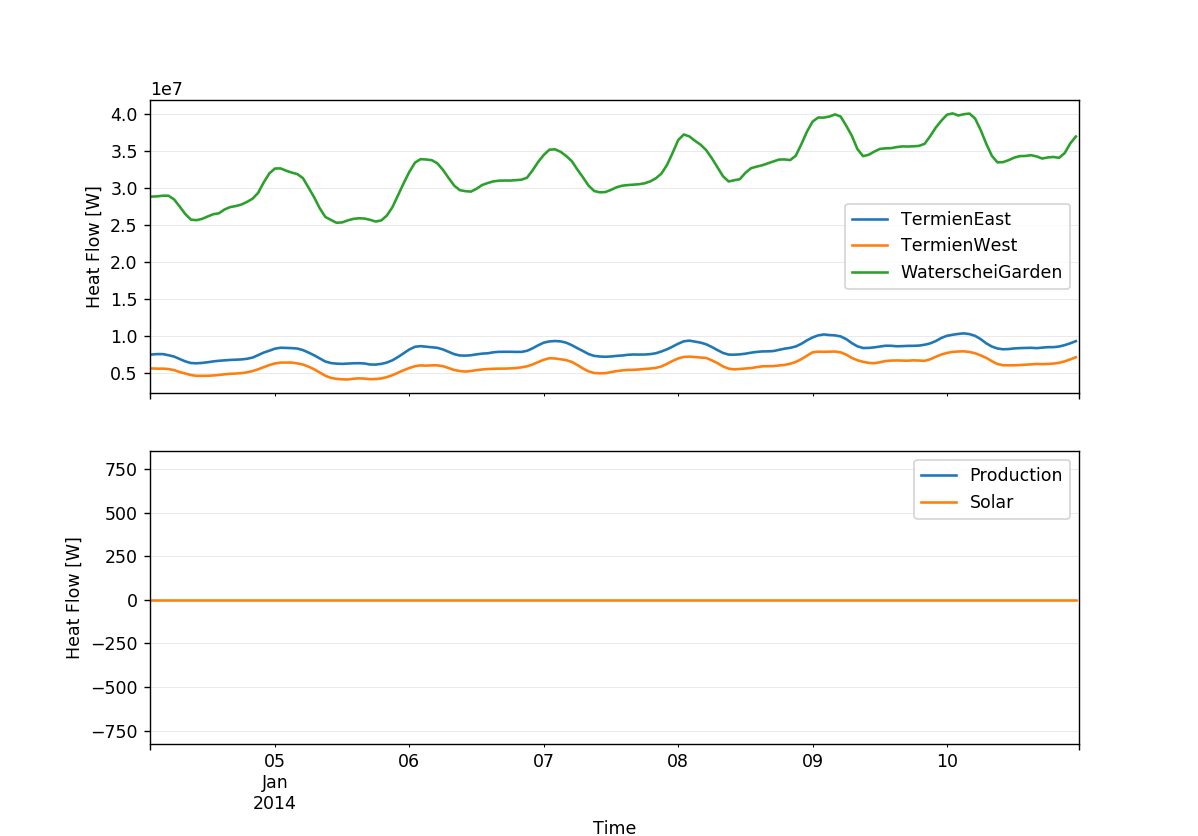

Text(0.5,0,u'Time')

In [33]:
from pandas.plotting._misc import (scatter_matrix, radviz,
                                   andrews_curves, bootstrap_plot,
                                   parallel_coordinates, lag_plot,
                                   autocorrelation_plot)
from pandas.plotting._core import boxplot
from pandas.plotting._style import plot_params
from pandas.plotting._tools import table

from pandas.plotting._converter import register as register_matplotlib_converters
from pandas.plotting._converter import deregister as deregister_matplotlib_converters

fig, ax = plt.subplots(2,1,sharex=True)

heat_flows.plot(ax=ax[0])
ax[0].set_ylabel('Heat Flow [W]')

inputs.plot(ax=ax[1])
ax[1].set_ylabel('Heat Flow [W]')

for a in ax:
    a.grid(linewidth=0.5, alpha=0.3)

ax[-1].set_xlabel('Time')

In [ ]:
optmodel.

In [27]:
ind = pd.DatetimeIndex(start='20140101', freq='3600S', periods=5)
df = pd.DataFrame(index=ind, data=[1,2,3,4,5], columns=['A'])

In [28]:
ind

DatetimeIndex(['2014-01-01 00:00:00', '2014-01-01 01:00:00',
               '2014-01-01 02:00:00', '2014-01-01 03:00:00',
               '2014-01-01 04:00:00'],
              dtype='datetime64[ns]', freq='3600S')

In [29]:
pltax = inputs.plot()

<IPython.core.display.Javascript object>

In [30]:
inputs.index

DatetimeIndex(['2014-01-04 00:00:00', '2014-01-04 01:00:00',
               '2014-01-04 02:00:00', '2014-01-04 03:00:00',
               '2014-01-04 04:00:00', '2014-01-04 05:00:00',
               '2014-01-04 06:00:00', '2014-01-04 07:00:00',
               '2014-01-04 08:00:00', '2014-01-04 09:00:00',
               ...
               '2014-01-10 14:00:00', '2014-01-10 15:00:00',
               '2014-01-10 16:00:00', '2014-01-10 17:00:00',
               '2014-01-10 18:00:00', '2014-01-10 19:00:00',
               '2014-01-10 20:00:00', '2014-01-10 21:00:00',
               '2014-01-10 22:00:00', '2014-01-10 23:00:00'],
              dtype='datetime64[ns]', length=168, freq='3600S')

## Storage unit

In [31]:
storage_stored_heat = optmodel.get_result('heat_stor', node='BuildingAndStorage',
                                  comp='storage')
storage_heat_flow = optmodel.get_result('heat_flow', node='BuildingAndStorage',
                                 comp='storage')

KeyError: 'BuildingAndStorage'

In [ ]:
fig1, (ax, ax2) = plt.subplots(2,1, sharex=True)
ax.plot(storage_stored_heat)
ax.set_title('Stored heat [kWh]')
ax2.plot(storage_heat_flow)
ax2.set_title('Heat flow to the tank [kWh]')
ax2.axhline(linestyle='--', color='g')

## Heat generation unit

In [ ]:
prod_hf = optmodel.get_result('heat_flow', node='Producer', comp='plant')
c_f = ut.read_period_data(path='../Data/ElectricityPrices',
                          name='DAM_electricity_prices-2014_BE.csv',
                          time_step=time_step, horizon=horizon,
                          start_time=start_time)['price_BE']

In [ ]:
fig, (ax, ax1) = plt.subplots(2, 1 , sharex=True)
ax.plot(prod_hf)

ax.axhline(y=0, linewidth=2, color='k', linestyle='--')
ax.set_title('Producer heat flows [W]')

ax1.plot(c_f)
ax1.set_title('Fuel price (electricity) euro/MWh')
ax1.legend()
#fig.tight_layout()

The plot clearly shows that the cost objective is followed, with the heat generation unit preferring moments of low electricity price to inject heat into the network.

Looking at the plots of the storage unit, you can see that most of this heat is stored there and used at a later time to keep the buildings sufficiently warm.

## Network efficiency

In [ ]:
# Heat flows
prod_hf = optmodel.get_result('heat_flow', node='Producer', comp='plant')
storage_hf = optmodel.get_result('heat_flow', node='BuildingAndStorage',
                                 comp='storage')
waterschei_hf = optmodel.get_result('heat_flow', node='BuildingAndStorage',
                                    comp='building')
zwartberg_hf = optmodel.get_result('heat_flow', node='Building',
                                   comp='building')


# Sum of heat flows
prod_e = sum(prod_hf)
storage_e = sum(storage_hf)
waterschei_e = sum(waterschei_hf)
zwartberg_e = sum(zwartberg_hf)

# Efficiency
print '\nNetwork efficiency', (storage_e + waterschei_e + zwartberg_e) / prod_e * 100, '%'
    